#Import Libraries

In [1]:
#import libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle as astropyAngle

## Define Functions. Note: All my functions accept angle in radians and return angle in radians

In [9]:

def gal2eq_radians(lon,lat):
    '''
    duffett-smith
    
    https://archive.org/details/
    Practical_Astronomy_with_your_Calculator_or_Spreadsheet_4th_edition_by_Peter_Duf
    
    lon: 0 to 2 pi
    lat: -pi/2 to pi/2
    ra: 0 to 2 pi
    dec: -pi/2 to pi/2
    '''   
    l0=32.9320*np.pi/180.
    dec0=27.1284*np.pi/180.
    ra0=192.8595*np.pi/180.
    
    sindec = np.cos(lat) * np.cos(dec0) * np.sin(lon-l0) + np.sin(lat)*np.sin(dec0)
    #print sindec

    tanraprime_y = np.cos(lat) * np.cos(lon-l0)
    #print tanraprime_y
    
    tanraprime_x = np.sin(lat) * np.cos(dec0) - np.cos(lat) * np.sin(dec0) * np.sin(lon-l0)
    #print tanraprime_x
    
    #print tanraprime_y/tanraprime_x
    
    raprime = np.arctan2(tanraprime_y,tanraprime_x)
    #print raprime*180./np.pi
    
    ra=raprime+ra0
    ra = (ra + 2 * np.pi) % (2 * np.pi)
    
    #print ra*180./np.pi
    
    dec = np.arcsin(sindec)
    
    return ra,dec

def eq2gal_radians(ra,dec):
    '''
    duffett-smith
        
    https://archive.org/details/
    Practical_Astronomy_with_your_Calculator_or_Spreadsheet_4th_edition_by_Peter_Duf
    
    lon: 0 to 2 pi
    lat: -pi/2 to pi/2
    ra: 0 to 2 pi
    dec: -pi/2 to pi/2

    '''   
    l0=32.9320*np.pi/180.
    dec0=27.1284*np.pi/180.
    ra0=192.8595*np.pi/180.
    
    sinlat = np.sin(dec)*np.sin(dec0) + np.cos(dec) * np.cos(dec0) * np.cos(ra-ra0)
    #print sinlat

    tanlprime_y = np.sin(dec) - sinlat * np.sin(dec0)
    #print tanlprime_y
    
    tanlprime_x = np.cos(dec) * np.sin(ra-ra0)* np.cos(dec0)
    #print tanlprime_x
    #print tanlprime_y/tanlprime_x
    
    lprime = np.arctan2(tanlprime_y,tanlprime_x)
    #print lprime*180/np.pi
    
    lon=lprime+l0
    lon = (lon + 2 * np.pi) % (2 * np.pi)
    #print lon
    
    lat=np.arcsin(sinlat)
    
    return lon,lat

def in_icecube_FOV(lon,lat,use_astropy=False):
    '''
    for a given lon, lat array of length N
    return a boolean array of length N 
    True: In icecube FOV
    FalsE: Not in icecube FOV
    
    This is for the Gamma ray analysis presented in ICRC
    https://pos.sissa.it/301/705/pdf
    '''
    if use_astropy:
        #standard function,more accurate,might be slow
        c=SkyCoord(l=lon*u.radian, b=lat*u.radian, frame='galactic')
        dec=c.fk5.dec.radian
        ra=c.fk5.ra.radian
    else:
        #use my function
        ra,dec=gal2eq_radians(lon,lat)
        
    zenith=dec+np.pi/2.0
    bool_array=np.cos(zenith)>=0.8
    
    return bool_array

# create mask over galactic coordinates
def return_mask_over_ic_fov(nside,use_astropy=False):
  
    npix=12*nside**2

    listpix = np.arange(npix)
    theta,phi = hp.pixelfunc.pix2ang(nside,listpix)
    b = np.pi/2.-theta
    l = phi

    mask = in_icecube_FOV(lon=l,lat=b,use_astropy=use_astropy)# for i,j in zip(l,b)]
    
    return mask

def move_gc_to_center(lon):
    l_t=astropyAngle(lon*u.radian)
    l_t=l_t.wrap_at(180.*u.deg).radian
    return l_t
        

# Plot whole sky & Ic FOV (use_astropy=False)

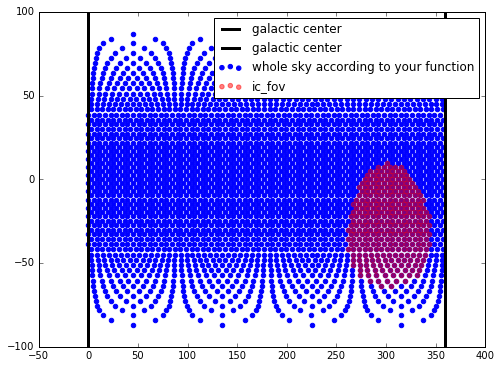

In [5]:
use_astropy=False
nside=16
npix=12*nside**2
listpix=np.arange(npix)
theta,phi=hp.pixelfunc.pix2ang(nside,listpix)
b=np.pi/2 - theta
l=phi
b=np.array(b);l=np.array(l)
ic_mask=return_mask_over_ic_fov(nside,use_astropy=use_astropy)
gc1=0
gc2=np.pi*2.0

plt.figure(figsize=(8,6))
plt.scatter(l*180/np.pi,b*180/np.pi,label='whole sky according to your function',color='b')
plt.scatter(l[ic_mask]*180/np.pi,b[ic_mask]*180/np.pi,
            label='ic_fov',
            color='r',alpha=0.5)
plt.axvline(x=gc1*180./np.pi,label='galactic center',color='k',lw=3)
plt.axvline(x=gc2*180./np.pi,label='galactic center',color='k',lw=3)
plt.legend(fontsize='large')

## Same plot as above but with GC in the middle of plot. By default the longitude values are 0 to 2pi but for plotting Galactic coordinates, one needs -pi to +pi and with x-axis flipped. That is what is done below

(180, -180)

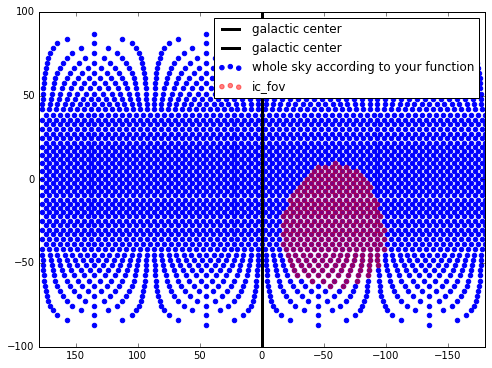

In [11]:
l_t=move_gc_to_center(l)
gc1_t=move_gc_to_center(gc1)
gc2_t=move_gc_to_center(gc2)

plt.figure(figsize=(8,6))
plt.scatter(l_t*180/np.pi,b*180/np.pi,label='whole sky according to your function',color='b')
plt.scatter(l_t[ic_mask]*180/np.pi,b[ic_mask]*180/np.pi,
            label='ic_fov',
            color='r',alpha=0.5)
plt.axvline(x=gc1_t*180./np.pi,label='galactic center',color='k',lw=3)
plt.axvline(x=gc2_t*180./np.pi,label='galactic center',color='k',lw=3)
plt.legend(fontsize='large')
plt.xlim([180,-180])

# Plot whole sky & Ic FOV (use_astropy=True)

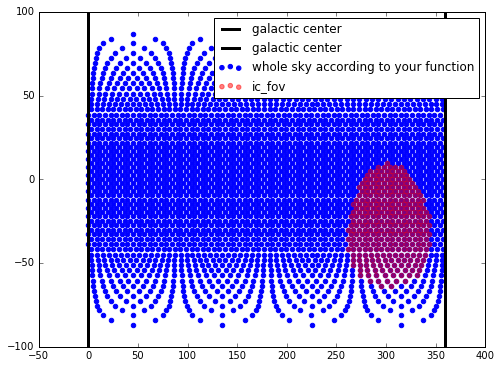

In [11]:
use_astropy=True
nside=16

npix=12*nside**2
listpix=np.arange(npix)
theta,phi=hp.pixelfunc.pix2ang(nside,listpix)
b=np.pi/2 - theta
l=phi
b=np.array(b);l=np.array(l)
ic_mask=return_mask_over_ic_fov(nside,use_astropy=use_astropy)
gc1=0
gc2=np.pi*2.0

plt.figure(figsize=(8,6))
plt.scatter(l*180/np.pi,b*180/np.pi,label='whole sky according to your function',color='b')
plt.scatter(l[ic_mask]*180/np.pi,b[ic_mask]*180/np.pi,
            label='ic_fov',
            color='r',alpha=0.5)
plt.axvline(x=gc1*180./np.pi,label='galactic center',color='k',lw=3)
plt.axvline(x=gc2*180./np.pi,label='galactic center',color='k',lw=3)
plt.legend(fontsize='large')

# Extra Stuff. Ignore it. 

In [6]:
# icecube fov is costheta 1.0 to 0.8 and all azimuth.
dec_resolution=50
ra_resolution=100
ic_dec=[]
ic_ra=[]
for ic_zenith in np.linspace(0.0,np.arccos(0.8),dec_resolution):
    for ic_azimuth in np.linspace(0,2.*np.pi,ra_resolution):
        ic_ra.append(ic_azimuth)
        ic_dec.append(ic_zenith-np.pi/2)
ic_ra=np.array(ic_ra)
ic_dec=np.array(ic_dec)

In [62]:
#South Pole Projection
map1=Basemap(projection='spstere',boundinglat=-50,lon_0=0)

#Draw Grid Lines
map1.drawmeridians(np.arange(0,360,15), linewidth=1, labels=[1,0,0,1], labelstyle='+/-')
map1.drawparallels(np.arange(-90,-45,5), linewidth=1, labels=[0,0,0,0], labelstyle='+/-')

#Draw Grid Labels

x,y=map1(45,-80)
plt.text(x,y,r'$-80^{o}$')
x,y=map1(45,-70)
plt.text(x,y,r'$-70^{o}$')
x,y=map1(45,-60)
plt.text(x,y,r'$-60^{o}$')
x,y=map1(45,-50)
plt.text(x,y,r'$-50^{o}$')


x,y=map1(ic_ra*180./np.pi, ic_dec*180./np.pi)
sc=map1.scatter(x, y,c='g',alpha=0.4,edgecolor='None')
plt.title('IceCube FOV in Equatorial Coordinates')
#plt.close()

In [85]:
# ConvexHull gives the vertices that define the edge of this FOV
# in Galactic coordinates
points=np.array([[lonFOV[i],latFOV[i]] for i in range(len(lonFOV))])
hull = ConvexHull(points)

#plot the boundary of IceCube FOV in GC
plt.figure()
plt.plot(points[hull.vertices,0]*180/np.pi, points[hull.vertices,1]*180./np.pi)
plt.xlabel('Longitude (deg)')
plt.ylabel('Lattitude (deg)')
plt.title('IceCube FOV in Galactic Coordinates')
plt.close()

In [28]:
#test a point in IceCube FOV
in_icecube_FOV(300*np.pi/180.,-30*np.pi/180.)
#test a point in CASA-MIA FOV
in_icecube_FOV(75*np.pi/180.,-4*np.pi/180.)
#test a point in ARGO-YBJ FOV
in_icecube_FOV(40*np.pi/180.,2*np.pi/180.)

False

False